# Import Data

4 classes:
['elephant', 'giraffe', 'lion', 'zebra']


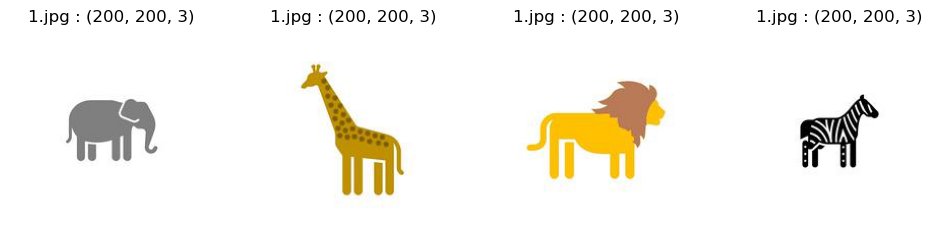

In [5]:
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

# The images are in the data/shapes folder
data_path = 'data/safari/training'

# Get the class names
classes = os.listdir(data_path)
classes.sort()
print(len(classes), 'classes:')
print(classes)

# Show the first image in each folder
fig = plt.figure(figsize=(12, 12))
i = 0
for sub_dir in os.listdir(data_path):
    i+=1
    img_file = os.listdir(os.path.join(data_path,sub_dir))[0]
    img_path = os.path.join(data_path, sub_dir, img_file)
    img = mpimg.imread(img_path)
    img_shape = np.array(img).shape
    a=fig.add_subplot(1, len(classes),i)
    a.axis('off')
    imgplot = plt.imshow(img)
    a.set_title(img_file + ' : ' + str(img_shape))
plt.show()

# Install and import libraries

In [3]:
import tensorflow
from  tensorflow import keras
print('TensorFlow version:',tensorflow.__version__)

TensorFlow version: 2.15.0


In [2]:
!pip show keras

Name: keras
Version: 2.15.0
Summary: Deep learning for humans.
Home-page: https://keras.io/
Author: Keras team
Author-email: keras-users@googlegroups.com
License: Apache 2.0
Location: C:\Users\Administrator\AppData\Roaming\Python\Python311\site-packages
Requires: 
Required-by: tensorflow-intel


# Prepare the data

In [6]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

img_size = (200, 200)
batch_size = 30

print("Getting Data...")
datagen = ImageDataGenerator(rescale=1./255, # normalize pixel values
                             validation_split=0.3) # hold back 30% of the images for validation

print("Preparing training dataset...")
train_generator = datagen.flow_from_directory(
    data_path,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='training') # set as training data

print("Preparing validation dataset...")
validation_generator = datagen.flow_from_directory(
    data_path,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation') # set as validation data

classnames = list(train_generator.class_indices.keys())
print('Data generators ready')

Getting Data...
Preparing training dataset...
Found 280 images belonging to 4 classes.
Preparing validation dataset...
Found 116 images belonging to 4 classes.
Data generators ready


# Define the CNN

In [26]:
# Define a CNN classifier network
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense

# Define the model as a sequence of layers
model = Sequential()

# The input layer accepts an image and applies a convolution that uses 32 6x6 filters and a rectified linear unit activation function
model.add(Conv2D(32, (6, 6), input_shape=train_generator.image_shape, activation='relu'))

# Next we'll add a max pooling layer with a 2x2 patch
model.add(MaxPooling2D(pool_size=(2,2)))

# We can add as many layers as we think necessary - here we'll add another convolution and max pooling layer
model.add(Conv2D(32, (6, 6), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# And another set
#model.add(Conv2D(32, (6, 6), activation='relu'))
#model.add(MaxPooling2D(pool_size=(2, 2)))

# A dropout layer randomly drops some nodes to reduce inter-dependencies (which can cause over-fitting)
model.add(Dropout(0.2))

# Flatten the feature maps 
model.add(Flatten())

# Generate a fully-connected output layer with a predicted probability for each class
# (softmax ensures all probabilities sum to 1)
model.add(Dense(train_generator.num_classes, activation='softmax'))

# With the layers defined, we can now compile the model for categorical (multi-class) classification
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

print(model.summary())

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 195, 195, 32)      3488      
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 97, 97, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_6 (Conv2D)           (None, 92, 92, 32)        36896     
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 46, 46, 32)        0         
 g2D)                                                            
                                                                 
 dropout_2 (Dropout)         (None, 46, 46, 32)        0         
                                                                 
 flatten_3 (Flatten)         (None, 67712)            

# Train the model

In [27]:
# Train the model over 5 epochs using 30-image batches and using the validation holdout dataset for validation
num_epochs = 5
history = model.fit(
    train_generator,
    steps_per_epoch = train_generator.samples // batch_size,
    validation_data = validation_generator, 
    validation_steps = validation_generator.samples // batch_size,
    epochs = num_epochs)

Epoch 1/5
9/9 [==============================] - 10s 862ms/step - loss: 3.2605 - accuracy: 0.3640 - val_loss: 1.1414 - val_accuracy: 0.3889
Epoch 2/5
9/9 [==============================] - 7s 799ms/step - loss: 0.9016 - accuracy: 0.6760 - val_loss: 0.5625 - val_accuracy: 0.9889
Epoch 3/5
9/9 [==============================] - 7s 776ms/step - loss: 0.4053 - accuracy: 0.9120 - val_loss: 0.2200 - val_accuracy: 0.9222
Epoch 4/5
9/9 [==============================] - 10s 1s/step - loss: 0.1259 - accuracy: 0.9720 - val_loss: 0.0247 - val_accuracy: 1.0000
Epoch 5/5
9/9 [==============================] - 14s 2s/step - loss: 0.0127 - accuracy: 1.0000 - val_loss: 0.0030 - val_accuracy: 1.0000


# View the loss history

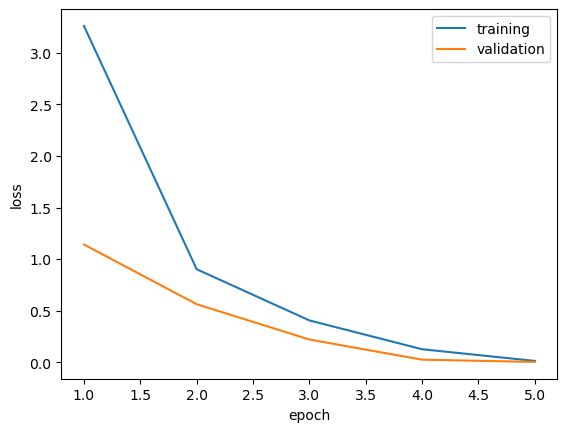

In [28]:
%matplotlib inline
from matplotlib import pyplot as plt

epoch_nums = range(1,num_epochs+1)
training_loss = history.history["loss"]
validation_loss = history.history["val_loss"]
plt.plot(epoch_nums, training_loss)
plt.plot(epoch_nums, validation_loss)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['training', 'validation'], loc='upper right')
plt.show()

# Evaluate model performance

Generating predictions from validation data...
1/1 [==============================] - 1s 569ms/step


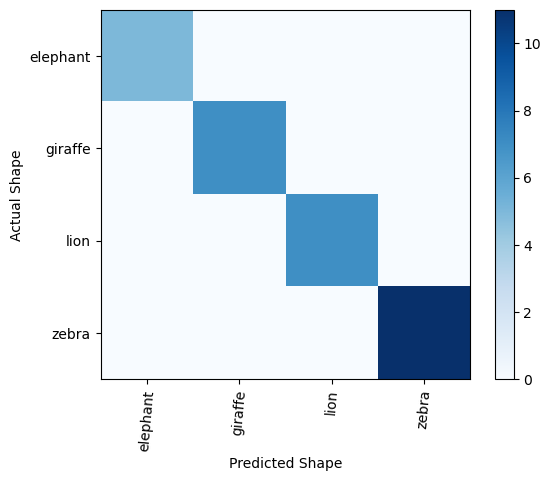

In [29]:
# Tensorflow doesn't have a built-in confusion matrix metric, so we'll use SciKit-Learn
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline

print("Generating predictions from validation data...")
# Get the image and label arrays for the first batch of validation data
x_test = validation_generator[0][0]
y_test = validation_generator[0][1]

# Use the model to predict the class
class_probabilities = model.predict(x_test)

# The model returns a probability value for each class
# The one with the highest probability is the predicted class
predictions = np.argmax(class_probabilities, axis=1)

# The actual labels are hot encoded (e.g. [0 1 0], so get the one with the value 1
true_labels = np.argmax(y_test, axis=1)

# Plot the confusion matrix
cm = confusion_matrix(true_labels, predictions)
plt.imshow(cm, interpolation="nearest", cmap=plt.cm.Blues)
plt.colorbar()
tick_marks = np.arange(len(classnames))
plt.xticks(tick_marks, classnames, rotation=85)
plt.yticks(tick_marks, classnames)
plt.xlabel("Predicted Shape")
plt.ylabel("Actual Shape")
plt.show()

# Save the Trained model

In [30]:
# Save the trained model
modelFileName = 'models/safari_classifier.h5'
model.save(modelFileName)
del model  # deletes the existing model variable
print('model saved as', modelFileName)

model saved as models/safari_classifier.h5


C:\Users\Administrator\AppData\Roaming\Python\Python311\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


# Use the trained model

1/1 [==============================] - 0s 107ms/step


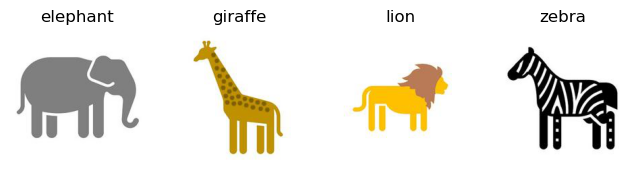

In [31]:
from tensorflow.keras import models
import numpy as np
import os
%matplotlib inline

# Function to predict the class of an image
def predict_image(classifier, image):
    from tensorflow import convert_to_tensor
    # The model expects a batch of images as input, so we'll create an array of 1 image
    imgfeatures = img.reshape(1, img.shape[0], img.shape[1], img.shape[2])

    # We need to format the input to match the training data
    # The generator loaded the values as floating point numbers
    # and normalized the pixel values, so...
    imgfeatures = imgfeatures.astype('float32')
    imgfeatures /= 255
    
    # Use the model to predict the image class
    class_probabilities = classifier.predict(imgfeatures)
    
    # Find the class predictions with the highest predicted probability
    index = int(np.argmax(class_probabilities, axis=1)[0])
    return index


# Load your model
model = models.load_model(modelFileName) # loads the saved model

# The images are in the data/shapes folder
test_data_path = 'data/safari/test'

# Show the test images with predictions
fig = plt.figure(figsize=(8, 12))
i = 0
for img_file in os.listdir(test_data_path):
    i+=1
    img_path = os.path.join(test_data_path, img_file)
    img = mpimg.imread(img_path)
    # Get the image class prediction
    index = predict_image(model, np.array(img))
    a=fig.add_subplot(1, len(classes),i)
    a.axis('off')
    imgplot = plt.imshow(img)
    a.set_title(classes[index])
plt.show()